# Progress report on GBDX investigation and evaluation. 

The free "community" version of GBDX permits unlimited access to Landsat8 data through the GBDX platform.  Most of the
interaction that GBDX supports (ordering images, scheduling computations on the images, etc.) should work identically
regardless of which satellite the image is pulled from, so testing some functionality with the Landsat8 data seemed
worthwhile, as it should carry over to work with the WorldView satellite data.

The obvious first task was to attempt to implement the ECARR index described in Giles et al. (2016).

It seemed reasonable to attempt to compare results of this implementation to those depicted in Figure 1 from [Giles et al. (2018)](https://www.nature.com/articles/s41598-018-27859-3) 

In [1]:
# Some boilerplate so we know what Python we are running:
import sys
sys.executable

'/Library/Frameworks/Python.framework/Versions/3.6/bin/python3.6'

In [2]:
# Where our Python lives:
sys.path

['',
 '/Library/Frameworks/Python.framework/Versions/3.6/lib/python36.zip',
 '/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6',
 '/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/lib-dynload',
 '/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages',
 '/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/IPython/extensions',
 '/Users/brian/.ipython']

In [1]:
# Prior to executing the pip installation below, first needed to do:  (in fish shell)
#  env PYCURL_SSL_LIBRARY=openssl LDFLAGS="-L/usr/local/opt/openssl/lib" CPPFLAGS="-I/usr/local/opt/openssl/include" /Library/Frameworks/Python.framework/Versions/3.6/bin/python3.6 -m pip install --no-cache-dir pycurl
# In bash shell, omit the "env"

##Install a pip package (gbdxtools) in the current Jupyter kernel
#import sys
#!{sys.executable} -m pip install gbdxtools


Figure 1 from [Giles (2018)](https://www.nature.com/articles/s41598-018-27859-3) showing the Canugra homebase north of Lamington National Park:

![Canungra ECARR](Giles2018.png "Title")


Lamington National Park is just south of the Canungra homebase and can be seen as the vaguely hand-shaped region with 
several "fingers" (mountain ridges) pointing to the northwest.  This region seemed like a good candidate for exploration,
as it features high ECARR levels but is very close to some agricultural fields, which should provide a chance to explore
the sensitivity of the ECARR index.

In the cell below, we pull a bounding box from a Landsat8 image focusing on this region.  

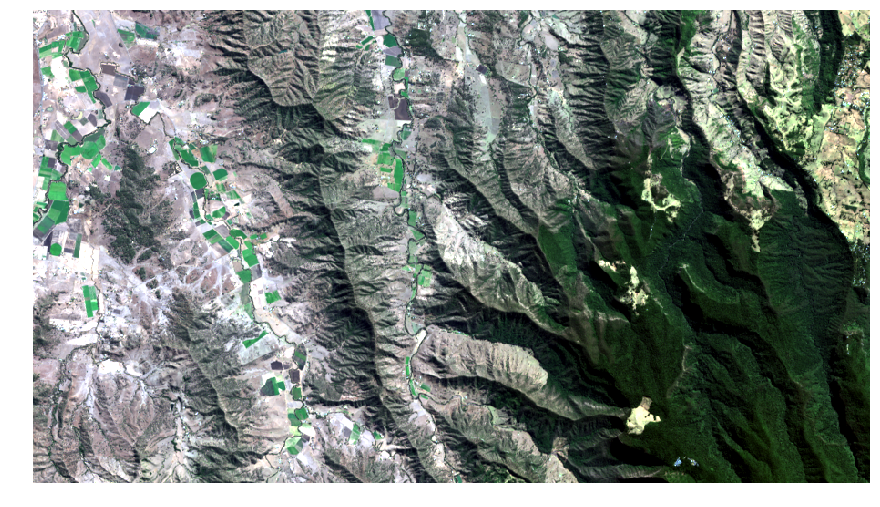

In [3]:
from gbdxtools.task import env
from gbdxtools import CatalogImage
%matplotlib inline

catalog_id = env.inputs.get('catalog_id', 'LC80890792018211LGN00') # image from 7/31/2018
bbox = env.inputs.get('bbox', '152.91389465332034, -28.23725437768062, 153.19473266601562, -28.09681795755814')

image = CatalogImage(catalog_id, band_type="MS", bbox=map(float, bbox.split(",")))
image.plot(w=15, h=12)


In [4]:
print(image.shape, image.bounds) # (8, 519, 919) -> We have an 8-band image.

(8, 519, 919) (491541.48218720144, 6876499.931700682, 519129.4875123252, 6892069.539201427)


In [11]:
# Small function to plot figures with colorbars:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

def mplot(image, w=15, h=12, cmap='jet'):
    f, ax = plt.subplots(1, figsize=(w,h))
    ax.axis('off')
    plt.imshow(image, cmap=cmap)
    plt.colorbar()
    plt.show()

GBDX itself does not implement a lot of functionality with respect to analysis, but it does provide a built-in function
to calculate the NDVI index.  Before attempting to implement the ECARR index, it seemed reasonable (as a sanity check)
to confirm that I could replicate identical results for the simpler NDVI index using my own code.

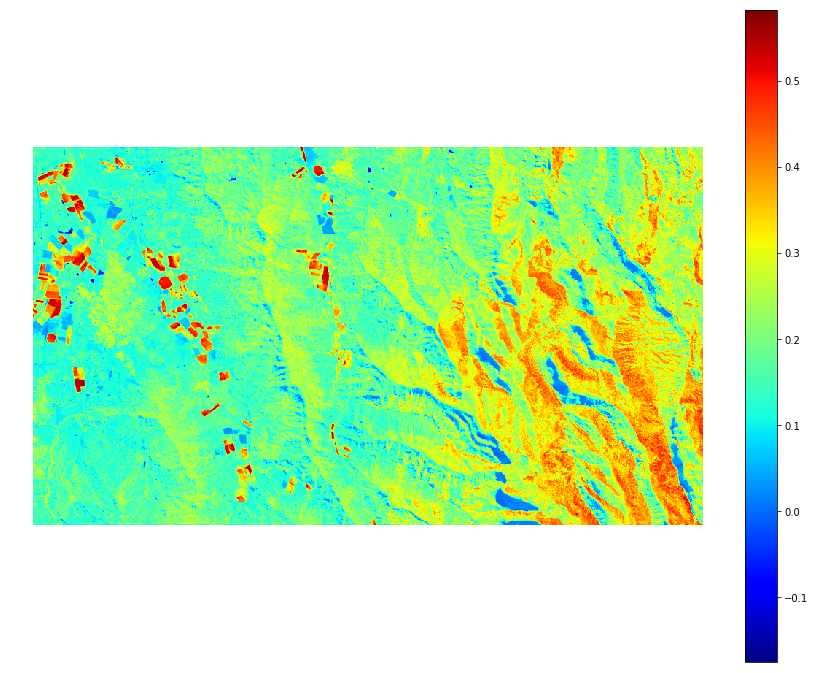

In [19]:
gbdx_ndvi = image.ndvi() # Built-in GBDX function
mplot(gbdx_ndvi)

In [9]:
# A trivial, "manual" implementation of NDVI:
data_ndvi = image.read([4,3]).astype(np.float32) # Reading the "Red" and "NIR" bands from Landsat8 images
recalc_ndvi = (data_ndvi[0,:,:] - data_ndvi[1,:,:]) / (data_ndvi[0,:,:] + data_ndvi[1,:,:])

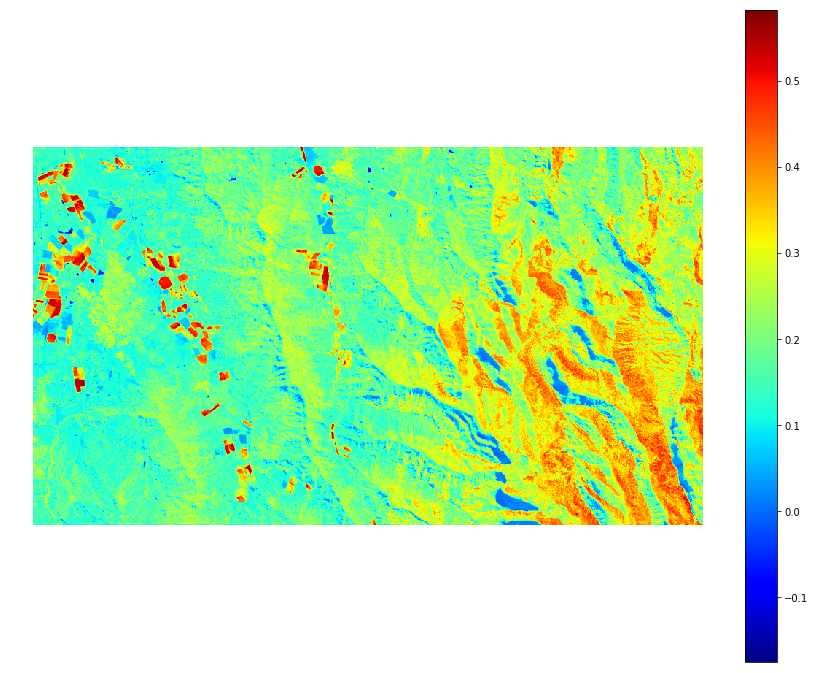

In [10]:
mplot(recalc_ndvi)


These results appear identical, and indeed, the absolute value of their difference is 0. So some hope exists for implementing ECARR as described in Table A1 of Giles et al., (2016).

In Bisun Datt's papers, four indices are empirically determined which use exact wavelengths to calculate the best correlation
to Eucalyptus a and Eucalyptus b (Datt, 1998) and corresponding versions less sensitive to moisture content (Datt, 1999).  Giles et al.
attempt to approximate these indices by substituting into Datt's formulas the MODIS satellite band levels which either contain 
or most closely adjoin the wavelengths used by Datt.

Giles et al. name these indices: ECARR1, ECBRR1, EWDI1, and EWDI2.

The forumlas for EWDI1 and EWDI2 appear to be obviously incorrect, in that the bands they use do not correspond to the 
wavelengths used by Datt in any consistent manner.  However, it is not clear to me what an appropriate fix would be,
as the wavelengths used by Datt are simply not available in either the MODIS or Landsat8 data.

In any case, the first task is to attempt to replicate ECARR as implemented by Giles et al.:

In [9]:
# Here are the bands for Landsat8: 

#Band 1 - Ultra Blue (coastal/aerosol)	0.435 - 0.451	30
#Band 2 - Blue	0.452 - 0.512	30
#Band 3 - Green	0.533 - 0.590	30
#Band 4 - Red	0.636 - 0.673	30
#Band 5 - Near Infrared (NIR)	0.851 - 0.879	30
#Band 6 - Shortwave Infrared (SWIR) 1	1.566 - 1.651	30
#Band 7 - Shortwave Infrared (SWIR) 2	2.107 - 2.294	30
#Band 8 - Panchromatic	0.503 - 0.676	15
#Band 9 - Cirrus	1.363 - 1.384	30
#Band 10 - Thermal Infrared (TIRS) 1	10.60 - 11.19	100 * (30)
#Band 11 - Thermal Infrared (TIRS) 2	11.50 - 12.51	100 * (30)

# For MODIS, as used by Giles, et al.

#Band	Bandwidth1	Spectral
#1	620 - 670	21.8	128  
#2	841 - 876	24.7	201
#3	459 - 479	35.3	243
#4	545 - 565	29.0	228 
#5	1230 - 1250	5.4	74
#6	1628 - 1652	7.3	275
#7	2105 - 2155	1.0	110


# "Aligning" bands:

# MODIS            #LS8

#1	620 - 670      636-673 #4 3  Red
#2	841 - 876      851 879 #5 4  NIR
#3	459 - 479      452 512 #2 1  blue
#4	545 - 565      533 590 #3 2  Green
#5	1230 - 1250
#6	1628 - 1652    1566 1651 #6 5 SWIR1
#7	2105 - 2155    2107 2294 #7 6 SWIR2

import numpy as np

# A function to calculate ECARR index:
def calc_ecarr(img):
    data_ecarr = img.read([3,4,5,6,2]).astype(np.float32)
    lsband4 = data_ecarr[0,:,:] # 3 Red
    lsband5 = data_ecarr[1,:,:] # 4 NIR
    lsband6 = data_ecarr[2,:,:] # 5 SWIR 1 
    lsband7 = data_ecarr[3,:,:] # 6 SWIR 2
    lsband3 = data_ecarr[4,:,:] # 2 Green

    # Renaming Landsat8 bands to MODIS bands:
    band1 = lsband4
    band2 = lsband5
    band4 = lsband3
    band6 = lsband6
    band7 = lsband7

    ecarr = 0.0161 * ((band2 / (band4 * band1) ) ** 0.7784)
     #ecbrr = (0.0337 * ((band1/band4) ** 1.8695))
    return(ecarr)
   


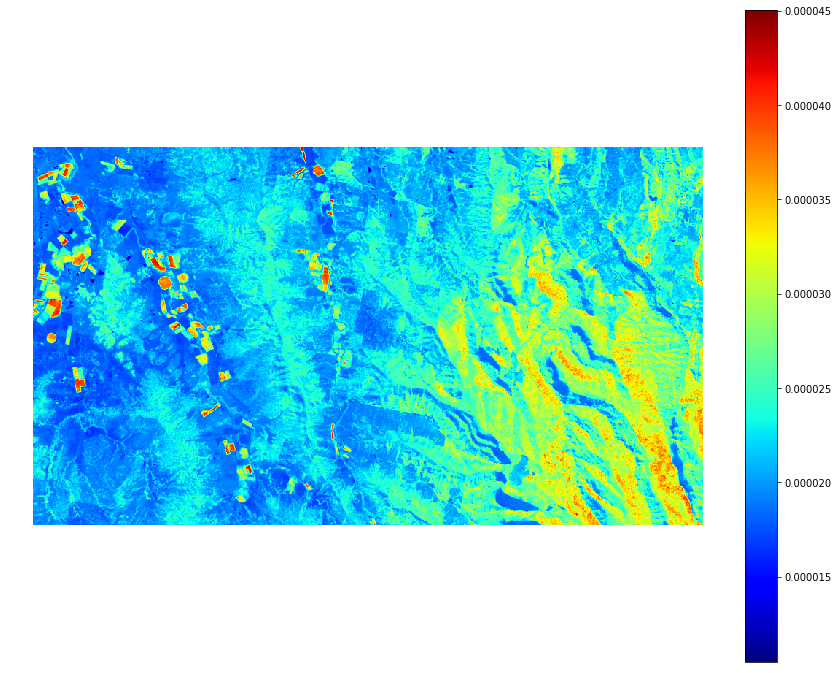

In [14]:
ecarr = calc_ecarr(image) # Using our implementation of Giles et al.'s ECARR
mplot(ecarr)

ECARR appears to be more sensitive to eucalypts than the broader NVDI index, as would be expected, but the very high 
levels observed in the agricultural fields to west suggest that the specificity of ECARR might not be sufficient to be 
determinative.  (Unless these are eucalyptus farms.)

Out of curiosity, I wanted to see if applying the atmospheric compensation correction routine provided by GBDX would
improve ECARR in any way.


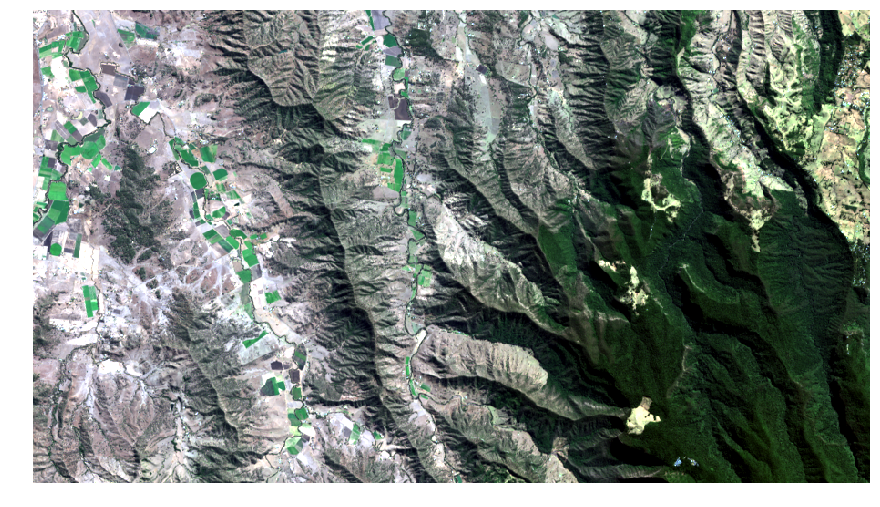

In [5]:
catalog_id = env.inputs.get('catalog_id', 'LC80890792018211LGN00') 
bbox = env.inputs.get('bbox', '152.91389465332034, -28.23725437768062, 153.19473266601562, -28.09681795755814')

# Here we apply atmospheric correction:
image_acomp = CatalogImage(catalog_id, band_type="MS", bbox=map(float, bbox.split(",")), acomp=True)
image_acomp.plot(w=15, h=12)

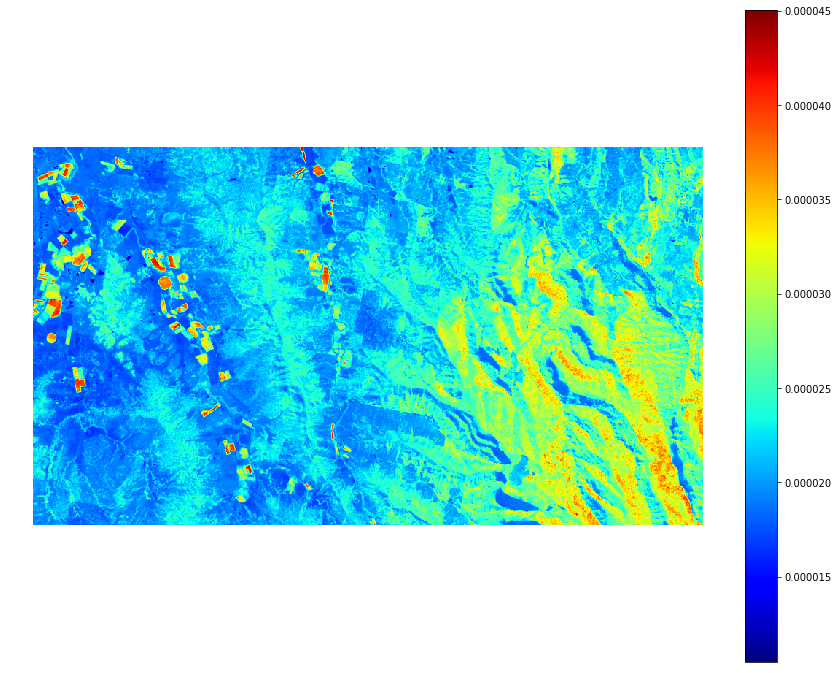

In [12]:
ecarr2 = calc_ecarr(image_acomp)
mplot(ecarr2)

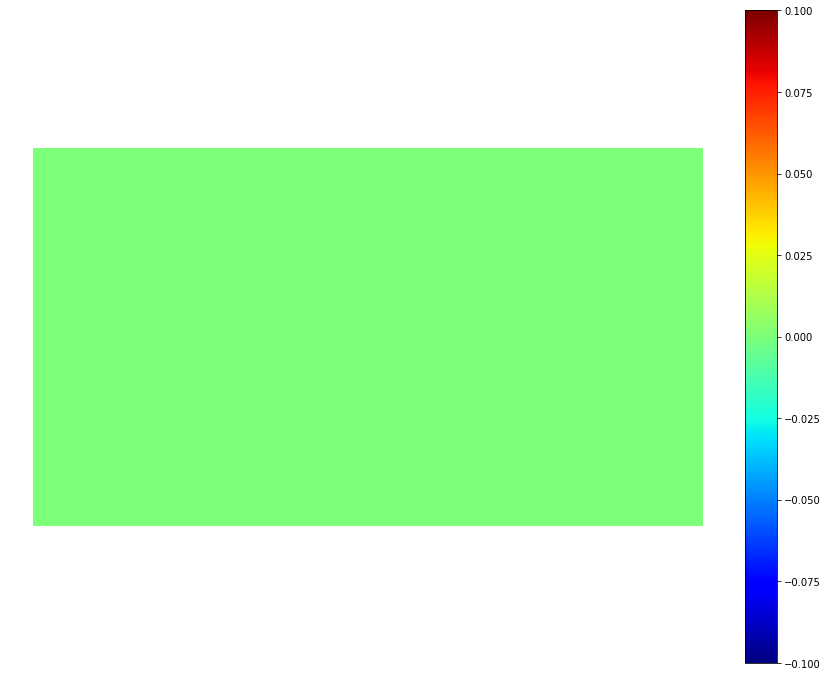

In [15]:
# In fact, atmospheric correction seems to have no effect on ECARR:
diff= abs(ecarr - ecarr2)
mplot(diff)


Finally, in order to perform at least a simple check of the Landsat8 approximation to the ECARR results from Figure 1
of Giles et al (2016), we apply our calc_ecarr function to a larger area.


In [13]:
from gbdxtools.task import env
from gbdxtools import CatalogImage

# image from 7/30/2018
bbox = env.inputs.get('bbox', '152.88230895996097, -28.555576049185973, 153.22013854980472, -28.078644626998408')

catalog_id1 = env.inputs.get('catalog_id1', 'LC80890802018211LGN00')
image_id1 = CatalogImage(catalog_id1, bbox=map(float, bbox.split(",")))

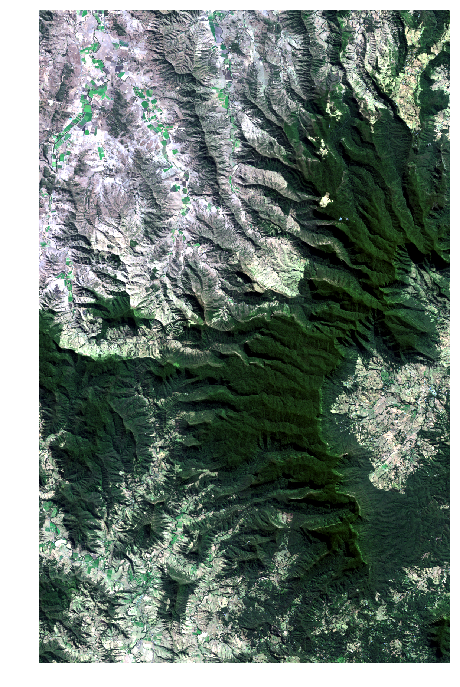

In [14]:
image_id1.plot(w=15, h=12)

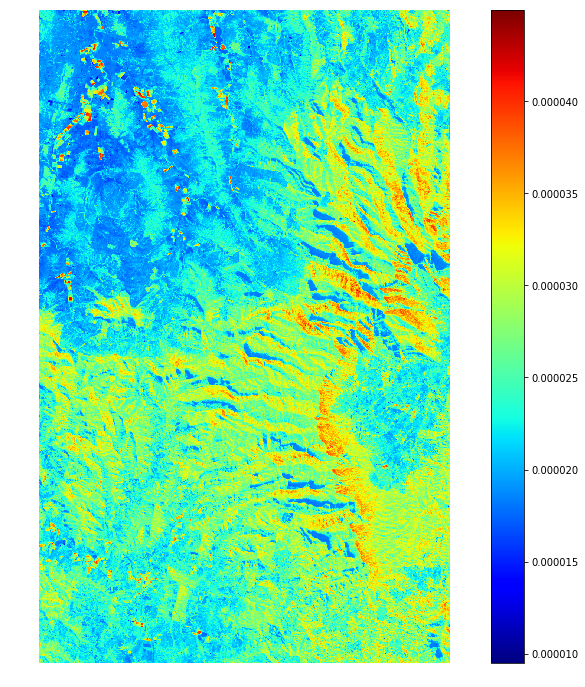

In [20]:
ecarr1 = calc_ecarr(image_id1)
mplot(ecarr1)


Below, we lay the plot just produced above, (adjusted to 50% opacity) over the corresponding region from Figure 1.  

![Canungra MODIS_ECARR and Landsat8_ECARR](Composite2.png "Canungra MODIS_ECARR and Landsat8_ECARR")

This appears to suggest that our implementation of a Landsat8 approximation to Giles et al.'s MODIS approximation is 
adequate to at least capture the level of variation that the MODIS approximation is producing. Notably, looking at 
their figure, it at appears to me that the region in which the agricultral fields lie is also color-coded as ECARR high.

Of course, I am assuming that they have either transformed and/or scaled their color bar, or applied some sort of threshold
to their values for ECARR. The color bar in their figure suggests that only ECARR values in the 99th percentile are being
regarded as actual eucalyptus, whereas the automatically generated color bar in the figure above suggests that LS8-ECARR
index values in the 50th percentile should be considered eucalyptus.    

Or pehaps this is an artifact of their covering a much larger space with much less eucalyptus, while the figure in this 
document is covering a smaller, eucalyptus rich space.  A good way to determine that might be to attempt to replicate
the entire region featured in their figure, which would also likely be a good way to test out the bulk-processing 
capabilities of GBDX.

# Observations 

- The GBDX system is tractable enough that performing continental scale analyses should be entirely feasible.
- It seems likely that ECARR and ECBRR can be implemented adequately; EWDI1 and EWDI2 do not seem feasible in any sensible way, at least immediately.

# Next Steps
- It may be worth extending LS8-ECARR over temporal and spatial scales before pulling the trigger on the 30-day evaluation.
- Extending over the temporal scale would give us an opportunity to quantify eucalyptus loss, and obviously seasonal flucations.
- The most interesting goals, bloom and bat localization, will absolutely require WorldView data only available during the active evaluation period.  

# To Investigate
- It might be possible to greatly improve LS8-ECARR (or our subsequent WorldView-ECARR).  The ECARR approximation seems fairly clumsy, just substituting broad band intensities for specific wavelengths.  It seems within the realm of possiblity that those intensities could be scaled to give us a better approximation to Datt's indexes.  I suspect there must be a signal processing/physics literature on exactly this issue, which I need to find.   